In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
import gymnasium
from gymnasium import spaces


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

In [3]:
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper

Aim of the moddeling:

- if you want to train multiple envs at once e.g. to do multiple abstraction levels design between: comprehensive levels as per Bathe, or scale (micro, macro), or different optimization objectives, or different action space, you can use SB3 Vectorized Environments in the below manner. For instance, for two or more Env you can combine the reward in any specific way thus ensuring communication between the abstraction levels.

In [4]:
y0, x0 = 5, 5

In [5]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [6]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [7]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [8]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [9]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [10]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [11]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [12]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [13]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [14]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [15]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [16]:
class CantileverEnvMicro(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2.1
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [17]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [18]:
class TotalRewardVecWrapper(VecEnvWrapper):
    def __init__(self, venv):
        super().__init__(venv)

    def step_wait(self):
        obs, rewards, dones, infos = self.venv.step_wait()
        total_reward = 2*np.multiply(*rewards)/np.sum(rewards)       
        rewards = np.full_like(rewards, total_reward)
        return obs, rewards, dones, infos
    
    def reset(self, seed=0):
        obs = self.venv.reset()
        return self.venv.reset() 

In [19]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X.reshape(y0, x0)) 
    plt.show() 

In [20]:
ts=3e6

In [21]:
# Create log dir
log_dir = "/tmp/gym6_2o1/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env1 = CantileverEnv()
check_env(env1)

In [22]:
# Create and wrap the environment
env2 = CantileverEnvMicro()
check_env(env1)

In [23]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [24]:
env = DummyVecEnv([lambda: env1, lambda: env2])

In [25]:
env.spec = env.envs[0].spec

In [26]:
# Create and wrap the environment
combined_venv = TotalRewardVecWrapper(env)
combined_venv  = VecMonitor(combined_venv , log_dir)

In [27]:
start=time.time()
model = PPO("MlpPolicy", combined_venv).learn(total_timesteps=ts, callback=callback)
end=time.time()  

Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6_2o1/best_model.zip
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 12000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 14000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 16000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 18000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 20000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 22000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 24000
Best mean reward: 0.00 - Last mean rew

Num timesteps: 190000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 192000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6_2o1/best_model.zip
Num timesteps: 194000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6_2o1/best_model.zip
Num timesteps: 196000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 198000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 200000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 202000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 204000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 206000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 208000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 210000
Best mean reward: 0.01 - Last mean reward per epis

Num timesteps: 372000
Best mean reward: 0.04 - Last mean reward per episode: 0.02
Num timesteps: 374000
Best mean reward: 0.04 - Last mean reward per episode: 0.01
Num timesteps: 376000
Best mean reward: 0.04 - Last mean reward per episode: 0.01
Num timesteps: 378000
Best mean reward: 0.04 - Last mean reward per episode: 0.01
Num timesteps: 380000
Best mean reward: 0.04 - Last mean reward per episode: 0.01
Num timesteps: 382000
Best mean reward: 0.04 - Last mean reward per episode: 0.02
Num timesteps: 384000
Best mean reward: 0.04 - Last mean reward per episode: 0.03
Num timesteps: 386000
Best mean reward: 0.04 - Last mean reward per episode: 0.03
Num timesteps: 388000
Best mean reward: 0.04 - Last mean reward per episode: 0.03
Num timesteps: 390000
Best mean reward: 0.04 - Last mean reward per episode: 0.03
Num timesteps: 392000
Best mean reward: 0.04 - Last mean reward per episode: 0.03
Num timesteps: 394000
Best mean reward: 0.04 - Last mean reward per episode: 0.01
Num timesteps: 3

Num timesteps: 570000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 572000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 574000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 576000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 578000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 580000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 582000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 584000
Best mean reward: 0.06 - Last mean reward per episode: 0.02
Num timesteps: 586000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 588000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 590000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 592000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 5

Num timesteps: 770000
Best mean reward: 0.06 - Last mean reward per episode: 0.05
Num timesteps: 772000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 774000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 776000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 778000
Best mean reward: 0.06 - Last mean reward per episode: 0.05
Num timesteps: 780000
Best mean reward: 0.06 - Last mean reward per episode: 0.05
Num timesteps: 782000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 784000
Best mean reward: 0.06 - Last mean reward per episode: 0.05
Num timesteps: 786000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Num timesteps: 788000
Best mean reward: 0.06 - Last mean reward per episode: 0.05
Num timesteps: 790000
Best mean reward: 0.06 - Last mean reward per episode: 0.02
Num timesteps: 792000
Best mean reward: 0.06 - Last mean reward per episode: 0.02
Num timesteps: 7

Num timesteps: 970000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 972000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 974000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 976000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 978000
Best mean reward: 0.06 - Last mean reward per episode: 0.02
Num timesteps: 980000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 982000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 984000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 986000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 988000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 990000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 992000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 9

Num timesteps: 1168000
Best mean reward: 0.06 - Last mean reward per episode: 0.02
Num timesteps: 1170000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 1172000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 1174000
Best mean reward: 0.06 - Last mean reward per episode: 0.01
Num timesteps: 1176000
Best mean reward: 0.06 - Last mean reward per episode: 0.03
Num timesteps: 1178000
Best mean reward: 0.06 - Last mean reward per episode: 0.05
Num timesteps: 1180000
Best mean reward: 0.06 - Last mean reward per episode: 0.04
Num timesteps: 1182000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Num timesteps: 1184000
Best mean reward: 0.06 - Last mean reward per episode: 0.07
Saving new best model to /tmp/gym6_2o1/best_model.zip
Num timesteps: 1186000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1188000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1190000
Best mean 

Num timesteps: 1362000
Best mean reward: 0.09 - Last mean reward per episode: 0.06
Num timesteps: 1364000
Best mean reward: 0.09 - Last mean reward per episode: 0.04
Num timesteps: 1366000
Best mean reward: 0.09 - Last mean reward per episode: 0.06
Num timesteps: 1368000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 1370000
Best mean reward: 0.09 - Last mean reward per episode: 0.05
Num timesteps: 1372000
Best mean reward: 0.09 - Last mean reward per episode: 0.05
Num timesteps: 1374000
Best mean reward: 0.09 - Last mean reward per episode: 0.03
Num timesteps: 1376000
Best mean reward: 0.09 - Last mean reward per episode: 0.01
Num timesteps: 1378000
Best mean reward: 0.09 - Last mean reward per episode: 0.02
Num timesteps: 1380000
Best mean reward: 0.09 - Last mean reward per episode: 0.02
Num timesteps: 1382000
Best mean reward: 0.09 - Last mean reward per episode: 0.01
Num timesteps: 1384000
Best mean reward: 0.09 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1558000
Best mean reward: 0.10 - Last mean reward per episode: 0.07
Num timesteps: 1560000
Best mean reward: 0.10 - Last mean reward per episode: 0.07
Num timesteps: 1562000
Best mean reward: 0.10 - Last mean reward per episode: 0.08
Num timesteps: 1564000
Best mean reward: 0.10 - Last mean reward per episode: 0.07
Num timesteps: 1566000
Best mean reward: 0.10 - Last mean reward per episode: 0.06
Num timesteps: 1568000
Best mean reward: 0.10 - Last mean reward per episode: 0.07
Num timesteps: 1570000
Best mean reward: 0.10 - Last mean reward per episode: 0.08
Num timesteps: 1572000
Best mean reward: 0.10 - Last mean reward per episode: 0.06
Num timesteps: 1574000
Best mean reward: 0.10 - Last mean reward per episode: 0.03
Num timesteps: 1576000
Best mean reward: 0.10 - Last mean reward per episode: 0.03
Num timesteps: 1578000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 1580000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1756000
Best mean reward: 0.10 - Last mean reward per episode: 0.03
Num timesteps: 1758000
Best mean reward: 0.10 - Last mean reward per episode: 0.03
Num timesteps: 1760000
Best mean reward: 0.10 - Last mean reward per episode: 0.03
Num timesteps: 1762000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1764000
Best mean reward: 0.10 - Last mean reward per episode: 0.05
Num timesteps: 1766000
Best mean reward: 0.10 - Last mean reward per episode: 0.06
Num timesteps: 1768000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1770000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 1772000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 1774000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 1776000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 1778000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1954000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1956000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1958000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1960000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1962000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1964000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1966000
Best mean reward: 0.10 - Last mean reward per episode: 0.04
Num timesteps: 1968000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 1970000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 1972000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 1974000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 1976000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2152000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 2154000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 2156000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 2158000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 2160000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 2162000
Best mean reward: 0.10 - Last mean reward per episode: 0.02
Num timesteps: 2164000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2166000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2168000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2170000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2172000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2174000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2350000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2352000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2354000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2356000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2358000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2360000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2362000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2364000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2366000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2368000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2370000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2372000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2548000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2550000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2552000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2554000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2556000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2558000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2560000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2562000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2564000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2566000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2568000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2570000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2746000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2748000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2750000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2752000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2754000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2756000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2758000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2760000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2762000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2764000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2766000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2768000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2944000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2946000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2948000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2950000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2952000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2954000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2956000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2958000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2960000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2962000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2964000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num timesteps: 2966000
Best mean reward: 0.10 - Last mean reward per episode: 0.01
Num 

In [28]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 57.222968796888985 min


In [29]:
obs=combined_venv.reset()

In [30]:
i=0
ans=[]
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = combined_venv.step(action)
    ans.append(obs)
    if any(dones):
        break
    
    i+=1


Final Cantilever beam design:


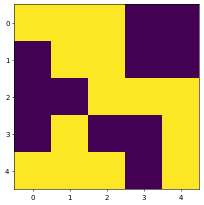

In [31]:
draw(ans[-2][0])


Final Cantilever beam design:


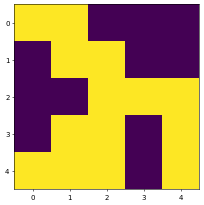

In [32]:
draw(ans[-2][1])

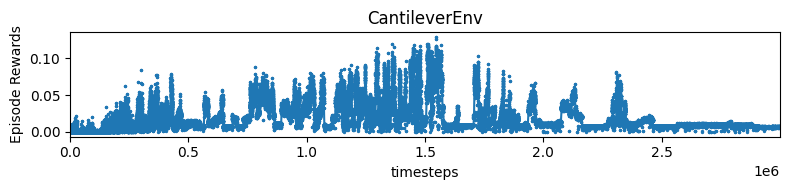

In [33]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [34]:
obs=combined_venv.reset()

In [35]:
model_best = PPO.load(log_dir + "best_model.zip", env=combined_venv)

In [36]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, info = combined_venv.step(action)
    ans.append(obs)
    if any(dones):
        break
    
    i+=1


Final Cantilever beam design:


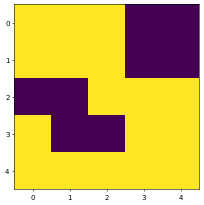

In [37]:
draw(ans[-2][0])


Final Cantilever beam design:


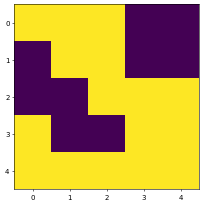

In [38]:
draw(ans[-2][1])